In [11]:
import random
from pathlib import Path
from multiprocessing import Pool

import cv2
import numpy as np
import import_ipynb
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils import *

In [12]:
df_train = pd.read_csv(train_csv_path, sep=",")
df_train["img_path"] =  df_train['image_id'].apply(build_image_path, convert_dtype=str)

df_test = pd.read_csv(test_csv_path, sep=",")
df_test["img_path"] =  df_test['image_id'].apply(build_image_path, convert_dtype=str)
df_train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/home/kasco/MDC/FinalProject/BreastCancerDetec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43739,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
43740,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
43741,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
43742,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,/home/kasco/MDC/FinalProject/BreastCancerDetec...


In [13]:
train_neg_samples_cnt, train_pos_samples_cnt = df_train['cancer'].value_counts()
test_neg_samples_cnt, test_pos_samples_cnt = df_test['cancer'].value_counts()

print(f"Train dataset: {train_neg_samples_cnt} negative samples and {train_pos_samples_cnt} positive samples")
print(f"Test dataset: {test_neg_samples_cnt} negative samples and {test_pos_samples_cnt} positive samples")

Train dataset: 42778 negative samples and 966 positive samples
Test dataset: 10770 negative samples and 192 positive samples


In [14]:
train_dataset_df, val_dataset_df = train_test_split(df_train, test_size=0.2, random_state=666, stratify=df_train['cancer'])


# split train dataset into negative and positive samples
train_normal_df = train_dataset_df[train_dataset_df['cancer'] == 0]
train_cancer_df = train_dataset_df[train_dataset_df['cancer'] == 1]

# split test dataset into negative and positive samples
val_normal_df = val_dataset_df[val_dataset_df['cancer'] == 0]
val_cancer_df = val_dataset_df[val_dataset_df['cancer'] == 1]


# dataset informations

print(f"Train dataset: {len(train_dataset_df)} samples")
print(f"Validation dataset: {len(val_dataset_df)} samples")

print(f"Train dataset: {len(train_normal_df)} normal samples and {len(train_cancer_df)} cancer samples")
print(f"Validation dataset: {len(val_normal_df)} normal samples and {len(val_cancer_df)} cancer samples")

Train dataset: 34995 samples
Validation dataset: 8749 samples
Train dataset: 34222 normal samples and 773 cancer samples
Validation dataset: 8556 normal samples and 193 cancer samples


In [15]:
def read_image(image_path: str) -> np.ndarray:
    img=cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
    return img

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)


transform = A.Compose([
    A.OneOf([
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
    ]),
    A.OneOf([
      A.CLAHE(p=0.5),
      A.RandomBrightnessContrast(p=0.5),
      A.RandomGamma(p=0.5),
      A.GaussianBlur(p=0.3, blur_limit=5),
    ]),
    A.OneOf([
      A.Affine(p=0.5, shear=10, rotate=5, mode=cv2.BORDER_CONSTANT),
      A.Rotate(p=0.5, limit=10, border_mode=cv2.BORDER_CONSTANT),
    ]),
    A.OneOf([
      A.CoarseDropout(p=0.3, max_holes=8, max_height=64, max_width=32, min_holes=2, min_height=32, min_width=32),
      A.CoarseDropout(p=0.3, max_holes=8, max_height=64, max_width=32, min_holes=2, min_height=32, min_width=32, fill_value=127),
    ])
])

/home/kasco/anaconda3/envs/mdc-tf-gpu/lib/python3.9/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


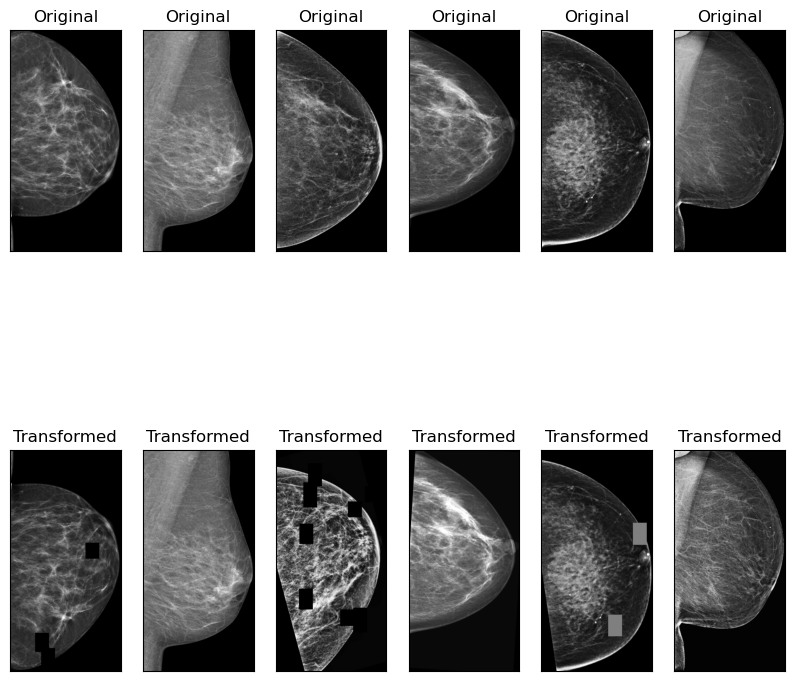

In [16]:
# Show original and augmented images for negative samples
ncols = 6
fig, axes = plt.subplots(nrows = 2, ncols = ncols, figsize = (10, 10), subplot_kw={'xticks':[], 'yticks':[]})
img_index = 0
for i, ax in enumerate(axes.flat):
    img = read_image(train_normal_df.iloc[img_index]['img_path'])
    if i <= ncols-1:
      # print('Original Image Properties')
      # print_img_props(img)
      ax.imshow(img, cmap='gray')
      ax.set_title('Original')
      if img_index == ncols-1:
        img_index = 0
      else:
        img_index += 1
    else:
      # print('Transformed Image Properties')
      # print_img_props(img)
      ax.imshow(transform(image=img)['image'], cmap='gray')
      ax.set_title('Transformed')
      img_index += 1
       
plt.show()

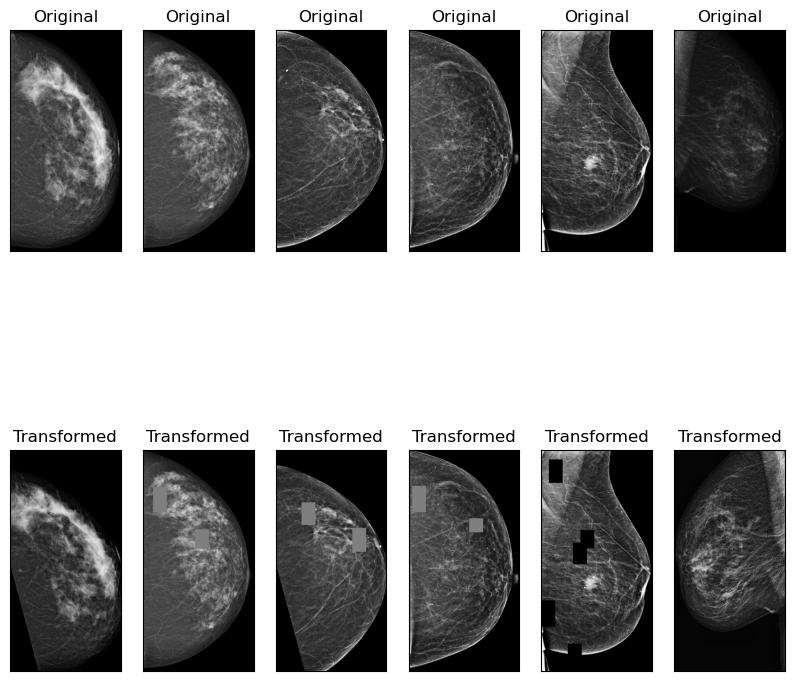

In [17]:
# Show original and augmented images of positive samples
ncols = 6
fig, axes = plt.subplots(nrows = 2, ncols = ncols, figsize = (10, 10), subplot_kw={'xticks':[], 'yticks':[]})
img_index = 0
for i, ax in enumerate(axes.flat):
    img = read_image(train_cancer_df.iloc[img_index]['img_path'])
    if i <= ncols-1:
      # print('Original Image Properties')
      # print_img_props(img)
      ax.imshow(img)
      ax.set_title('Original')
      if img_index == ncols-1:
        img_index = 0
      else:
        img_index += 1
    else:
      # print('Transformed Image Properties')
      # print_img_props(img)
      ax.imshow(transform(image=img)['image'])
      ax.set_title('Transformed')
      img_index += 1
       
plt.show()

In [18]:
clean_all_datasets()

# Criando os diretórios:
create_dataset_dirs()

In [19]:
# get augmentation ratio
aug_train_ratio = int(len(train_normal_df)/len(train_cancer_df))
aug_val_ratio = int(len(val_normal_df)/len(val_cancer_df))
normal_aug_factor = 2

print(f"Positive augmentation ratio for train dataset: {aug_train_ratio}")
print(f"Positive augmentation ratio for validation dataset: {aug_val_ratio}\n")

print('Desired number of normal samples for train dataset: ', len(train_normal_df)*normal_aug_factor)
print('Desired number of cancer samples for train dataset: ', len(train_cancer_df)*aug_train_ratio*normal_aug_factor, "\n")

print('Desired number of normal samples for validation dataset: ', len(val_normal_df)*normal_aug_factor)
print('Desired number of cancer samples for validation dataset: ', len(val_cancer_df)*aug_val_ratio*normal_aug_factor)


Positive augmentation ratio for train dataset: 44
Positive augmentation ratio for validation dataset: 44

Desired number of normal samples for train dataset:  68444
Desired number of cancer samples for train dataset:  68024 

Desired number of normal samples for validation dataset:  17112
Desired number of cancer samples for validation dataset:  16984


In [20]:
# augmentation and dataset balancing for train normal samples
def augment_normal_train(df):
    for row in df.itertuples(index=False):
      ori_image = read_image(row.img_path)
      cv2.imwrite(str(Path(train_normal_dir_path, str(row.image_id) + '.png').resolve()), ori_image)
      for i in range(normal_aug_factor):
          aug_image = transform(image=ori_image)['image']
          cv2.imwrite(str(Path(train_normal_dir_path, str(row.image_id) + f'_{i}.png').resolve()), aug_image)

with Pool(8) as p:
    r = list(tqdm(p.map(augment_normal_train, np.array_split(train_normal_df, 50)), total=50))

In [ ]:
# augmentation and dataset balancing for train cancer samples
def augment_cancer_train(df):
    for row in df.itertuples(index=False):
      ori_image = read_image(row.img_path)
      cv2.imwrite(str(Path(train_cancer_dir_path, str(row.image_id) + '.png').resolve()), ori_image)
      for i in range(aug_train_ratio*normal_aug_factor):
          aug_image = transform(image=ori_image)['image']
          cv2.imwrite(str(Path(train_cancer_dir_path, str(row.image_id) + f'_{i}.png').resolve()), aug_image)

with Pool(8) as p:
    r = list(tqdm(p.map(augment_cancer_train, np.array_split(train_cancer_df, 50)), total=50))


In [ ]:
# augmentation and dataset balancing for validation normal samples
def augment_normal_val(df):
    for row in df.itertuples(index=False):
      ori_image = read_image(row.img_path)
      cv2.imwrite(str(Path(val_normal_dir_path, str(row.image_id) + '.png').resolve()), ori_image)
      for i in range(normal_aug_factor):
          aug_image = transform(image=ori_image)['image']
          cv2.imwrite(str(Path(val_normal_dir_path, str(row.image_id) + f'_{i}.png').resolve()), aug_image)

with Pool(8) as p:
    r = list(tqdm(p.map(augment_normal_val, np.array_split(val_normal_df, 50)), total=50))

In [ ]:
# augmentation and dataset balancing for val cancer samples
def augment_cancer_val(df):
    for row in df.itertuples(index=False):
      ori_image = read_image(row.img_path)
      cv2.imwrite(str(Path(val_cancer_dir_path, str(row.image_id) + '.png').resolve()), ori_image)
      for i in range(aug_val_ratio*normal_aug_factor):
          aug_image = transform(image=ori_image)['image']
          cv2.imwrite(str(Path(val_cancer_dir_path, str(row.image_id) + f'_{i}.png').resolve()), aug_image)

with Pool(8) as p:
    r = list(tqdm(p.map(augment_cancer_val, np.array_split(val_cancer_df, 50)), total=50))
